In [1]:
%matplotlib inline

In [2]:
from pymatgen.io.cif import CifParser
from pathlib import Path
import numpy as np
from pymatgen.core.periodic_table import DummySpecies, Element
from pymatgen.core.sites import PeriodicSite
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
from matplotlib import pyplot as plt

base_material = "MoS2"
unit_cell = CifParser(Path(
            "..",
            "defects_generation",
            "molecules",
            f"{base_material}.cif")).get_structures(primitive=False)[0]
supercell_size = (8, 8, 1)
reference_supercell = unit_cell.copy()
reference_supercell.make_supercell(supercell_size)

/home/kna/.cache/pypoetry/virtualenvs/2d-defects-potential-learning-pYjw2mkT-py3.8/lib/python3.8/site-packages/pymatgen/io/cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [3]:
rng = np.random.default_rng(42)

In [4]:
extreme_defects_freqences = {
    Element("Mo"): {
        Element("W"): 0.5,
        DummySpecies(): 0.05
    },
    Element("S"): {
        Element("Se"): 0.5,
        DummySpecies(): 0.20
    }
}

In [5]:
def get_site_indices_by_species(structure, specie):
    """
    Returns site indices with given specie.
    """
    return [i for i, site in enumerate(structure) if site.specie == specie]

In [6]:
def generate_structure(defects_frequences):
    """
    Creates structure with defects with given frequences.
    """
    supercell = reference_supercell.copy()
    for original_element, this_defects_frequences in defects_frequences.items():
        element_indices = get_site_indices_by_species(reference_supercell, original_element)
        permuted_indices = rng.permutation(element_indices)
        if sum(this_defects_frequences.values()) > 1:
            raise ValueError("Sum of defect frequencies must be less than 1.")
        
        permutation_start = 0
        for defect_specie, defect_frequency in this_defects_frequences.items():
            permutation_end = permutation_start + int(len(element_indices) * defect_frequency)
            for i_np in permuted_indices[permutation_start:permutation_end]:
                i = int(i_np)
                supercell[i] = PeriodicSite(
                    species=defect_specie,
                    coords=supercell[i].coords,
                    lattice=supercell[i].lattice,
                    coords_are_cartesian=True)
            permutation_start = permutation_end
    # Remove dummy sites aka vacancies
    supercell.remove_sites([i for i, site in enumerate(supercell) if site.specie == DummySpecies()])
    return supercell

In [7]:
def generate_defect_description(defects_frequences):
    """
    Generates defect description in the Innopolist format
    """
    defects = []
    for original_element, this_defects_frequences in defects_frequences.items():
        reference_supercell_element_count = len(get_site_indices_by_species(reference_supercell, original_element))
        for defect_specie, defect_frequency in this_defects_frequences.items():
            defect_count = int(reference_supercell_element_count * defect_frequency)
            if isinstance(defect_specie, DummySpecies):
                defects.extend([{"type": "vacancy", "element": original_element.symbol}]*defect_count)
            else:
                defects.extend([{"type": "substitution", "from": original_element.symbol, "to": defect_specie.symbol}]*defect_count)
    return defects

In [8]:
from collections import defaultdict
def generate_short_description(defect_description, element_order=["Mo", "S"]):
    """
    Outputs a short description from a full description in Innopolis format.
    Warning: all substitutions are conflated in a single number
    """
    substitution_counts = defaultdict(int)
    vacancy_counts = defaultdict(int)
    for defect in defect_description:
        if defect["type"] == "substitution":
            substitution_counts[defect["from"]] += 1
        elif defect["type"] == "vacancy":
            vacancy_counts[defect["element"]] += 1
        else:
            raise ValueError("Unknown defect type: {}".format(defect["type"]))
    return "".join(f"S{substitution_counts[element]}V{vacancy_counts[element]}" for element in element_order)

In [9]:
generation_parameters = []
for Mo_vacancy_frequency in [0, 0.01, 0.05]:
    for Mo_W_substitution_frequency in np.linspace(0.1, 0.9-Mo_vacancy_frequency, 5):
        for S_vacancy_frequency in [0, 0.1, 0.2]:
            for S_Se_substitution_frequency in np.linspace(0.1, 0.9-S_vacancy_frequency, 5):
                generation_parameters.append({
                    Element("Mo"): {
                        Element("W"): Mo_W_substitution_frequency,
                        DummySpecies(): Mo_vacancy_frequency
                    },
                    Element("S"): {
                        Element("Se"): S_Se_substitution_frequency,
                        DummySpecies(): S_vacancy_frequency
                    }
                })

In [10]:
#TODO(Ruslan) replace uuid with the MongoDB ids
import uuid
import pandas as pd
structures_per_parameters = 30
descriptors_dict = {
    "_id": [], "description": [], "base": [], "cell": [], "defects": []}
structures_dict = {
    "_id": [], "descriptor_id": []
}

#TODO(Ruslan) replace folder with high_density_of_defects_mongodb_ids
target_folder = Path("../datasets/others/high_density_of_defects_random_ids/")
target_folder.mkdir(parents=True, exist_ok=True)
structures_folder = target_folder / "poscars"
structures_folder.mkdir(exist_ok=True)
max_generation_tries = 10
reference_species_order = [Element("Mo"), Element("W"), Element("Se"), Element("S")]

for params in generation_parameters:
    description = generate_defect_description(params)
    defect_id = uuid.uuid4().hex

    descriptors_dict["_id"].append(defect_id)
    descriptors_dict["description"].append(generate_short_description(description))
    descriptors_dict["base"].append(base_material)
    descriptors_dict["cell"].append(supercell_size)
    descriptors_dict["defects"].append(description)

    this_structures = []

    for _ in range(structures_per_parameters):
        structure_id = uuid.uuid4().hex
    
        is_unique = False
        tries = 0
        while not is_unique:
            if tries > max_generation_tries:
                raise ValueError("Maximum number of tries exceeded for genrating a unique structure.")
            structure = generate_structure(params)
            tries += 1
            is_unique = True
            for previous_structure in this_structures:
                if structure.matches(previous_structure):
                    is_unique = False
                    break
        structure = structure.get_sorted_structure()
        
        if len(structure.types_of_species) != len(reference_species_order) or \
            not all(structure.types_of_species[i] == reference_species_order[i]
            for i in range(len(structure.types_of_species))):
            
            print(structure.species)
            raise ValueError("Structure species are not in the correct order.")
        this_structures.append(structure)
        structures_dict["_id"].append(structure_id)
        structures_dict["descriptor_id"].append(defect_id)
        structure.to("POSCAR", structures_folder / f"POSCAR_{structure_id}")

descriptors_pd = pd.DataFrame.from_dict(descriptors_dict)
descriptors_pd.set_index(["_id"], inplace=True)
descriptors_pd.to_csv(target_folder / "descriptors.csv")

structures_pd = pd.DataFrame.from_dict(structures_dict)
structures_pd.set_index(["_id"], inplace=True)
structures_pd.to_csv(target_folder / "defects.csv")

In [11]:
example_structure = generate_structure(extreme_defects_freqences)
# plot an example structure with ASE's ngl viewer
from ase.visualize import view
atoms = AseAtomsAdaptor.get_atoms(example_structure)
view(atoms, viewer="ngl")


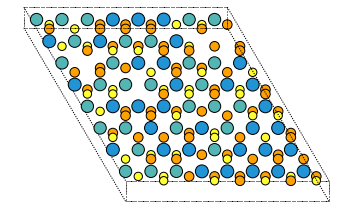

In [12]:
example_structure = generate_structure(extreme_defects_freqences)
ase_atoms = AseAtomsAdaptor.get_atoms(example_structure)
fig, ax = plt.subplots()
plot_atoms(ase_atoms, ax, radii=0.5, rotation=('10x, 0y, 0z'), show_unit_cell=True)
xlim = 40
ylim = 23
ax.set_xlim(-2, xlim)
ax.set_ylim(-2, ylim)
ax.set_axis_off()
fig.savefig("example_structure.png", dpi=300)